In [1]:
import networkx as nx
import torch
from torch_geometric.data import Data
import torch_geometric
import numpy as np
from torch_geometric.datasets import CoraFull, CitationFull
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd

from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import ToUndirected
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric.transforms import ToUndirected
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal,StaticGraphTemporalSignal

from Trainer_loocv import Trainer
from utils_temporal import get_distance, draw_graph, nearest_neighbors_graph, plot_heatmap, dataset_generation
from sklearn.preprocessing import LabelEncoder
device = 'cuda' if torch.cuda.is_available() else 'cpu'

%config InlineBackend.figure_format = 'retina'


In [2]:
df = pd.read_csv('data/final_data_mar.csv.gz')

In [3]:
df.head()

,time,station_id,longitude,latitude,PM25_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled
0,2014-05-01 00:00:00,1002,116.20531,40.00395,89.0,0.0,20.0,56.0,7.92,13.0,False
1,2014-05-01 01:00:00,1002,116.20531,40.00395,85.0,0.0,18.0,64.0,7.56,13.0,False
2,2014-05-01 02:00:00,1002,116.20531,40.00395,88.0,0.0,18.0,70.0,5.76,13.0,False
3,2014-05-01 03:00:00,1002,116.20531,40.00395,100.0,0.0,17.0,74.0,6.12,13.0,False
4,2014-05-01 04:00:00,1002,116.20531,40.00395,109.0,0.0,17.0,75.0,4.68,1.0,False


In [4]:
le = LabelEncoder()
df['station_id'] = le.fit_transform(df['station_id'])

In [5]:
# list_node_features = []
# list_edge_list = []
# list_target_features = []

# for i in tqdm(df["time"].unique()):
#     list_node_features.append(df[df["time"] == i][["longitude", "latitude" ,"temperature", "humidity", "wind_speed", "wind_direction"]].to_numpy())
#     list_target_features.append(df[df["time"] == i][["PM25_Concentration"]].to_numpy())
# list_target_features = np.array(list_target_features)
# list_node_features = np.array(list_node_features)
# np.save("list_node_features.npy", list_node_features)
# np.save("list_target_features.npy", list_target_features)

In [6]:
list_node_features = np.load("list_node_features.npy")
list_target_features = np.load("list_target_features.npy")

In [7]:
list_node_features.shape

(8760, 30, 6)

In [8]:
num_timesteps_in = 12
# x = df[df["time"] == "2014-05-01 00:00:00"]
final_node_features = []
final_target_features = []
indices = [
            (i, i + (num_timesteps_in))
            for i in range(df["time"].unique().shape[0] - (num_timesteps_in))
        ]

for i,j in indices:
    final_node_features.append(list_node_features[i:i+num_timesteps_in,:,:])
    final_target_features.append(list_target_features[j])


In [9]:
final_node_features = np.array(final_node_features).transpose(0, 2, 3, 1)
final_target_features = np.array(final_target_features)


In [10]:
print(final_node_features.shape)
print(final_target_features.shape)

(8748, 30, 6, 12)
(8748, 30, 1)


In [11]:
df["station_id"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [12]:
def nearest_neighbors_graph(df):

    G = nx.Graph()

    for i in df.station_id.unique():
        G.add_node(i)
    for i in df.station_id.unique():
        for j in df.station_id.unique():
            if i != j:
                G.add_edge(i, j, weight=1/get_distance(df[df["station_id"]==i]["latitude"].values[0],
                                                       df[df["station_id"]==i]["longitude"].values[0],       
                                                       df[df["station_id"]==j]["latitude"].values[0],
                                                       df[df["station_id"]==j]["longitude"].values[0]))
    
    return G

In [13]:
sub_df = df[df["time"] == "2014-05-01 00:00:00"]
G = nearest_neighbors_graph(sub_df)

In [14]:
# draw the graph with edge weights
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)
# labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# plt.show()

In [15]:
list_edge_list = [(edge[0], edge[1]) for edge in G.edges]
list_edge_weights = [G.edges[edge]["weight"] for edge in G.edges]

In [16]:
np.array(list_edge_weights).shape

(435,)

In [17]:
list_edge_list = np.array(list_edge_list)
list_edge_weights = np.array(list_edge_weights).reshape(-1,1)

In [18]:
print(list_edge_list.shape)
print(list_edge_weights.shape)

(435, 2)
(435, 1)


In [19]:
dataset = StaticGraphTemporalSignal(edge_index= np.array(list_edge_list).T, features=np.array(final_node_features), targets=np.array(final_target_features), edge_weight=np.array(list_edge_weights).squeeze())

In [20]:
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric.nn import GCNConv
from torch.nn import Linear
from torch.nn import LSTM
import torch.nn as nn

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, batch_size, window_size, num_nodes):
        super(TemporalGNN, self).__init__()
        self.window = window_size
        self.num_nodes = num_nodes
        self.in_channels = node_features
        self.batch_size = batch_size
        self.hidden_size = 32
        self._create_parameters_and_layers()
    def _create_parameters_and_layers(self):

        self._convolution_1 = GCNConv(self.in_channels, self.hidden_size)
        self._convolution_2 = GCNConv(self.hidden_size, self.hidden_size)

        self._recurrent_1 = nn.LSTM(2 * self.hidden_size, self.hidden_size, 1)
        self._recurrent_2 = nn.LSTM(self.hidden_size, self.hidden_size, 1)
    
    def _graph_convolution_1(self, X, edge_index, edge_weight):
        X = F.relu(self._convolution_1(X, edge_index, edge_weight))
        return X
    def _graph_convolution_2(self, X, edge_index, edge_weight):
        X = F.relu(self._convolution_2(X, edge_index, edge_weight))
        return X

    def forward(self, X, edge_index,edge_weight):

        R = list()

        S = X.view(-1, self.window, self.num_nodes, self.in_channels)
        S = torch.transpose(S, 1, 2)
        S = S.reshape(-1, self.window, self.in_channels)
        O = [S[:, 0, :]]

        for l in range(1, self.window):
            O.append(S[:, l, self.in_channels - 1].unsqueeze(1))

        S = torch.cat(O, dim=1)

        X = self._graph_convolution_1(X, edge_index, edge_weight)
        R.append(X)

        X = self._graph_convolution_2(X, edge_index, edge_weight)
        R.append(X)

        X = torch.cat(R, dim=1)

        X = X.view(-1, self.window, self.num_nodes, X.size(1))
        X = torch.transpose(X, 0, 1)
        X = X.contiguous().view(self.window, -1, X.size(3))

        X, (H_1, _) = self._recurrent_1(X)
        X, (H_2, _) = self._recurrent_2(X)

        H = torch.cat([H_1[0, :, :], H_2[0, :, :], S], dim=1)
        return H

model = TemporalGNN(node_features=6, batch_size=32, window_size=12, num_nodes=30)
model


TemporalGNN(
  (_convolution_1): GCNConv(6, 32)
  (_convolution_2): GCNConv(32, 32)
  (_recurrent_1): LSTM(64, 32)
  (_recurrent_2): LSTM(32, 32)
)

In [21]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [22]:
train_dataset[0]

Data(x=[30, 6, 12], edge_index=[2, 435], edge_attr=[435], y=[30, 1])

In [23]:
model = TemporalGNN(node_features=6, batch_size=32, window_size=12, num_nodes=30).to(device)

In [24]:
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(device)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(device)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=32, shuffle=True,drop_last=True)

In [25]:
test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(device)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(device)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=32, shuffle=True,drop_last=True)

In [26]:
test_dataset_new[0][0].shape

torch.Size([30, 6, 12])

In [28]:
gcn = GCNConv(6, 32).cpu()
print(gcn(test_dataset_new[0][0].detach().cpu(),static_edge_index.detach().cpu()))

RuntimeError: index 6 is out of bounds for dimension 0 with size 6

In [69]:
static_edge_index.shape

torch.Size([2, 435])

In [61]:
test_target.shape

(1750, 30, 1)

In [27]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(device)
    static_edge_weight = snapshot.edge_attr.to(device)
    break;

In [63]:
for encoder_inputs, labels in train_loader:
    print(encoder_inputs.shape)
    print(labels.shape)
    break;

torch.Size([32, 30, 6, 12])
torch.Size([32, 30, 1])


In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
model.train()

for epoch in tqdm(range(10)):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index,static_edge_weight)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [5,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [6,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [7,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [8,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1670525541990/work/at

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5760x12 and 6x32)

In [46]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 8467.4184


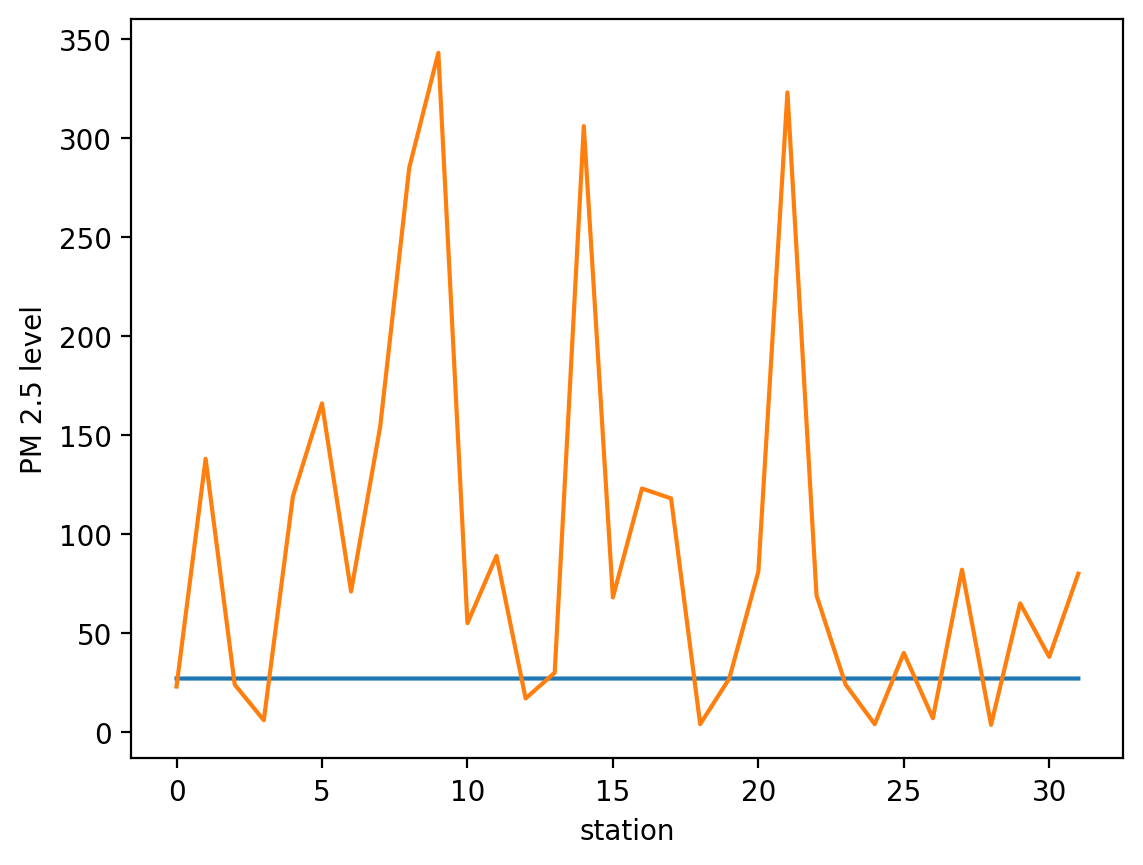

In [54]:

plt.plot(y_hat[:,0,:].detach().cpu().numpy(), label="prediction")
plt.plot(labels[:,0,:].detach().cpu().numpy(), label="actual")
plt.ylabel("PM 2.5 level")
plt.xlabel("station")
plt.show();

In [19]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()


In [20]:
dataset[0]

Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])